# Purpose

This script is an implementation of SHAP (SHapley Additive exPlanations) for the `leaky_basic_5` model. 

### Modules

In [1]:
import os
import pandas as pd
import shap
import imp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

shap.explainers._deep.deep_tf.op_handlers["LeakyRelu"] = shap.explainers._deep.deep_tf.op_handlers["Relu"]
shap.initjs()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses


### Custom Modules

In [3]:
# import custom modules
this_dir = "/Users/steeleb/Documents/GitHub/NASA-NW/modeling/SMR_temp_forecast/arNN/"
imp.load_source("universals", os.path.join(this_dir, "universal_functions.py"))
from universals import load_pickle_file, twotemp_labels_features_test

### Load data and models

First, we'll load in the training sets

In [4]:
data_dir = "/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/"

all_files = pd.Series(os.listdir(data_dir))
t2023 = all_files[all_files.str.contains('t2023')]
t2023_train = t2023[t2023.str.contains('training')]

# these files end up in no particular order, so we need to sort them
t2023_train = t2023_train.sort_values()

def load_data(file):
    return pd.read_csv(os.path.join(data_dir, file), sep=',')

train1 = load_data(t2023_train.values[0])

train2 = load_data(t2023_train.values[1])

train3 = load_data(t2023_train.values[2])

train4 = load_data(t2023_train.values[3])

train5 = load_data(t2023_train.values[5])

train6 = load_data(t2023_train.values[5])

train7 = load_data(t2023_train.values[6])

train8 = load_data(t2023_train.values[7])

train9 = load_data(t2023_train.values[8])

And we need to process these for ML-ready format. Since we're only using the training data, we can use the get_features_labels_test function

In [5]:
features_1, labels_1 = twotemp_labels_features_test(train1)
features_2, labels_2 = twotemp_labels_features_test(train2)
features_3, labels_3 = twotemp_labels_features_test(train3)
features_4, labels_4 = twotemp_labels_features_test(train4)
features_5, labels_5 = twotemp_labels_features_test(train5)
features_6, labels_6 = twotemp_labels_features_test(train6)
features_7, labels_7 = twotemp_labels_features_test(train7)
features_8, labels_8 = twotemp_labels_features_test(train8)
features_9, labels_9 = twotemp_labels_features_test(train9)


And the pickle files for each of the models

In [6]:
model_dir = "/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/models/leaky_basic_5_t2023/"

models = [f for f in os.listdir(model_dir) if 'history' not in f]

model_1 = load_pickle_file(models[0], model_dir)
model_2 = load_pickle_file(models[1], model_dir)
model_3 = load_pickle_file(models[2], model_dir)
model_4 = load_pickle_file(models[3], model_dir)
model_5 = load_pickle_file(models[4], model_dir)
model_6 = load_pickle_file(models[5], model_dir)
model_7 = load_pickle_file(models[6], model_dir)
model_8 = load_pickle_file(models[7], model_dir)
model_9 = load_pickle_file(models[8], model_dir)

### Model 1

In [7]:
explainer_1 = shap.DeepExplainer(model_1, pd.DataFrame.to_numpy(features_1))
shap_values_1 = explainer_1.shap_values(pd.DataFrame.to_numpy(features_1))

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2024-12-01 12:31:44.345699: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


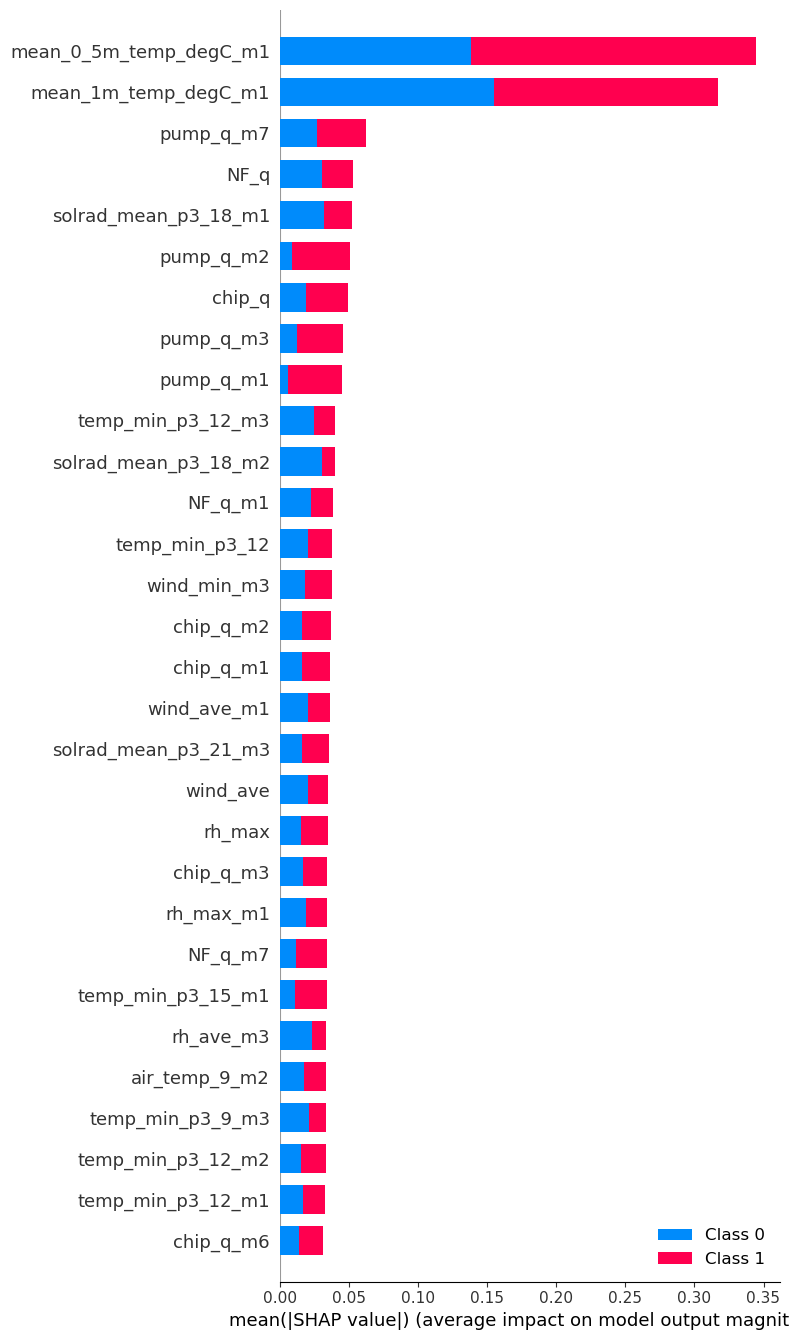

In [10]:
shap_1 = shap.summary_plot(shap_values_1, features_1, plot_type="bar", max_display=30)


And plot the SHAP

In [11]:
# Reduce noise by taking means of sorted 1% segments of the data
def get_percentile_stats(arr, sortarr, num=100, func=np.mean):
    sorted_arr = arr[np.argsort(sortarr)]  # Sorts arr based on values in sortarr
    split_arrs = np.array_split(sorted_arr, num)  # Splits the array into [num] lists
    meanslist = list(map(func, split_arrs))  # Applies np.mean to all arrays in split_arrs
    return np.array(meanslist)  # Returns array of the means for [num] sorted segments of arr


# Plot out the Shapley Values in a more visually appealing format
def plot_shap(shapvals, featurevals, feature_names, mod_identity):
    # Number of samples
    samp_num = shapvals.shape[0]

    # Init colormap
    n = len(feature_names)
    color = iter(plt.cm.get_cmap("viridis")(np.linspace(0, 1, n)))

    for varindex, varname in enumerate(feature_names):
        # Step color
        c = next(color)

        # Get the avg feature val for every 5 percentiles of shap values
        featuremean_for_shappercentile = get_percentile_stats(featurevals[:, varindex], shapvals[:, varindex])

        # Get the median shap val for every 5 percentiles of shap values
        shapmedian_for_shappercentile = get_percentile_stats(
            shapvals[:, varindex], shapvals[:, varindex], func=np.median
        )

        # Plot
        plt.plot(featuremean_for_shappercentile, shapmedian_for_shappercentile, "o", label=varname, color=c)
        plt.axhline(0, zorder=0, color="k", alpha=0.1)
        plt.axvline(0, zorder=0, color="k", alpha=0.1)

    plt.xlim(-3, 3)
    plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")

    plt.ylabel("Median Shap Value")
    plt.xlabel("Mean Feature Value")
    plt.title(
        "SHAP Values and Feature Values For Model " + str(mod_identity)
    )
    plt.show()

In [ ]:
plot_shap(shap_values_1[0], pd.DataFrame.to_numpy(features_1), features_1.columns, 1)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


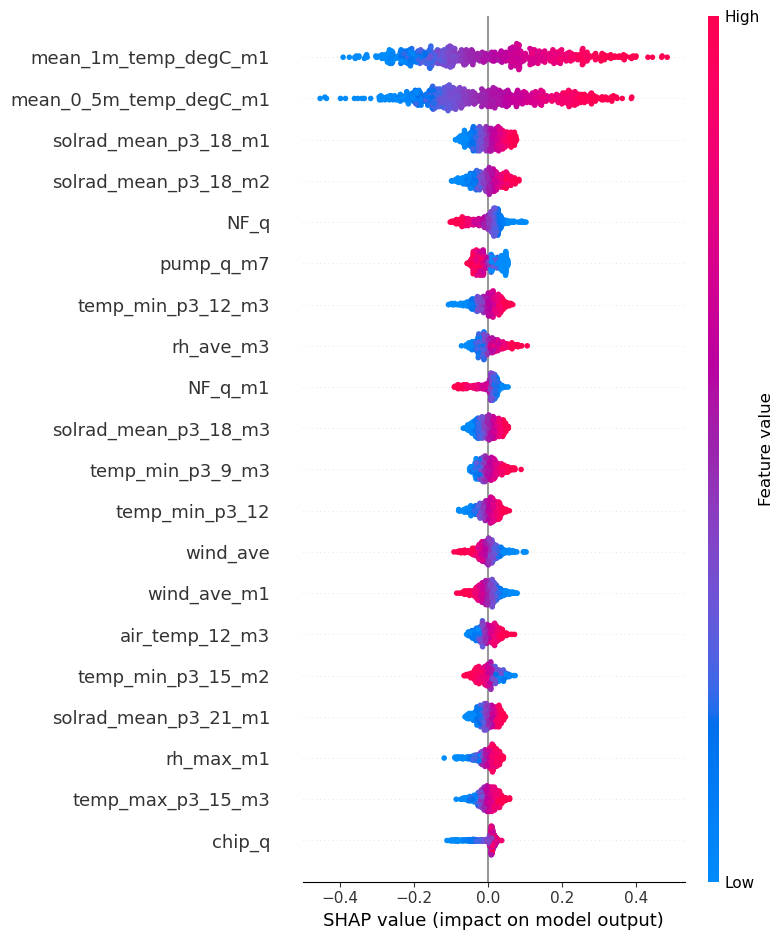

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


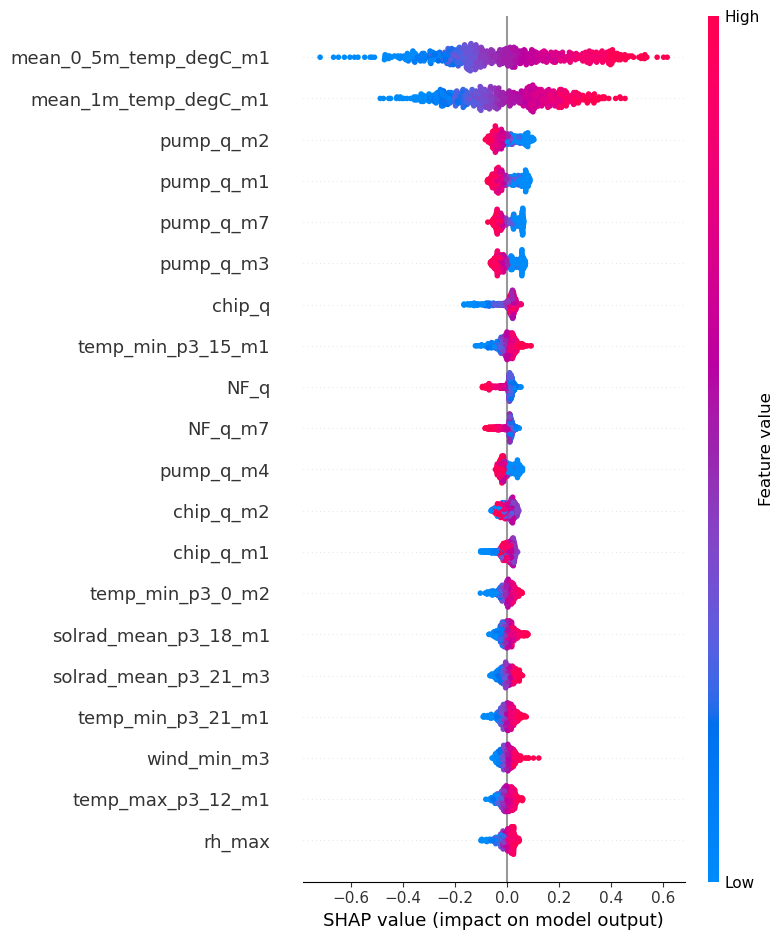

In [12]:
shap.summary_plot(shap_values_1[0], features_1)
shap.summary_plot(shap_values_1[1], features_1)

No one is surprised here, the most important features are yesterday's temperature values. While pumping is not 'highly important', it is one of the few features that has a strong negative impact on the model temperature prediction (i.e. the higher the pumping, the lower the temperature). Which is what we want to see. Given this, let's apply this model to the test data, see how it performs, and then play with the pump values to see how it impacts the temperature.